<p style="font-size:40px">Feature Selection</p> <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu, chi2_contingency
from scipy.stats import shapiro
import scipy.stats as ss

from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score, accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import warnings
warnings.filterwarnings("ignore")

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
bank = pd.read_csv('data\bank_clean.csv')

In [3]:
bank.head()

,age,job,marital,education,default,month,campaign,pdays,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [12]:
bank['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'university.degree', 'illiterate'],
      dtype=object)

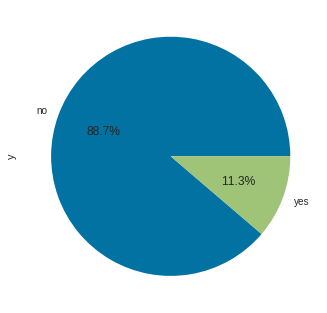

In [4]:
bank['y'].value_counts().plot(kind = 'pie',autopct='%1.1f%%')

> Terlihat bahwa dataset ini highly-unbalanced

# Hypothesis Testing

> <p style="font-family:'Courier New'">Melakukan tes hipotesis ke dataset berguna untuk memastikan bahwa semua fitur-fitur yang digunakan mempunyai pengaruh atau ada perbedaan yang signifikan secara statisik pada target. 

In [5]:
categorical = list(bank.select_dtypes('object').columns.drop('y'))
numerical = list(bank.drop(list(bank.select_dtypes('object').columns), axis = 1).columns)

## Normality Test

In [6]:
shap = []

for i in numerical:
    if shapiro(bank[i])[1] < 0.05:
        shap.append('Reject Null Hypothesis')
    else:
        shap.append('Fail To reject Null Hypothesis')
        
pd.DataFrame({'Hypothesis' : shap}, index = numerical)

,Hypothesis
age,Reject Null Hypothesis
campaign,Reject Null Hypothesis
emp.var.rate,Reject Null Hypothesis
cons.price.idx,Reject Null Hypothesis
cons.conf.idx,Reject Null Hypothesis
euribor3m,Reject Null Hypothesis
nr.employed,Reject Null Hypothesis


## Significance Test

In [7]:
mannwhit = []

for i in numerical:
    if mannwhitneyu(bank[bank['y'] == 'no'][i],bank[bank['y'] == 'yes'][i])[1] < 0.05:
        mannwhit.append('Reject Null Hypothesis')
    else:
        mannwhit.append('Fail To reject Null Hypothesis')

pd.DataFrame({'Hypothesis' : mannwhit}, index = numerical)

,Hypothesis
age,Reject Null Hypothesis
campaign,Reject Null Hypothesis
emp.var.rate,Reject Null Hypothesis
cons.price.idx,Reject Null Hypothesis
cons.conf.idx,Reject Null Hypothesis
euribor3m,Reject Null Hypothesis
nr.employed,Reject Null Hypothesis


In [8]:
chi2 = []

for i in categorical:
    if chi2_contingency(pd.crosstab(bank['y'], bank[i]))[1] < 0.05:
        chi2.append('Reject Null Hypothesis')
    else:
        chi2.append('Fail To Reject Null Hypothesis')
        
pd.DataFrame({'Hypothesis' : chi2}, index = categorical)

,Hypothesis
job,Reject Null Hypothesis
marital,Reject Null Hypothesis
education,Reject Null Hypothesis
default,Reject Null Hypothesis
month,Reject Null Hypothesis
pdays,Reject Null Hypothesis
poutcome,Reject Null Hypothesis


> <p style="font-family:'Courier New'">Terlihat dari signifikansi tes di atas, bahwa fitur-fitur yang di dataset setelah dibersihkan adalah fitur-fitur yang signifikan. 

# Preprocessing

## Feature Selection


<p style="font-family:'Courier New'">Pada feature selection saya menggunakan analisa korelasi, yang dimana jika korelasi fitur terhadap target tidak ada (dalam asumsi saya, korelasi < 0.2 artinya fitur tersebut tidak punya korelasi). Maka akan saya buang fiturnya. 

In [9]:
#Correlation measurement untuk data discrete dan continous
def correlation_ratio(categories, measurement):
    fcat,_ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurement[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array, y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurement,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

#Correlation measurement untuk data discrete dan discrete
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

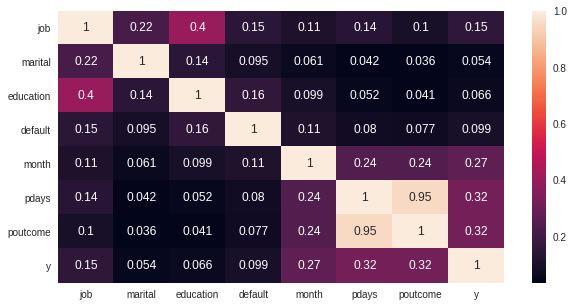

In [10]:
category = bank.select_dtypes(exclude = np.number)

corrCat = []
for i in category.columns:
    mat = []
    for j in category.columns:
        mat.append(cramers_v(bank[i],bank[j]))
    corrCat.append(mat)
    
dfcramers = pd.DataFrame(corrCat, index = category.columns, columns = category.columns)
plt.figure(figsize = (10,5))
sns.heatmap(dfcramers,annot = True)

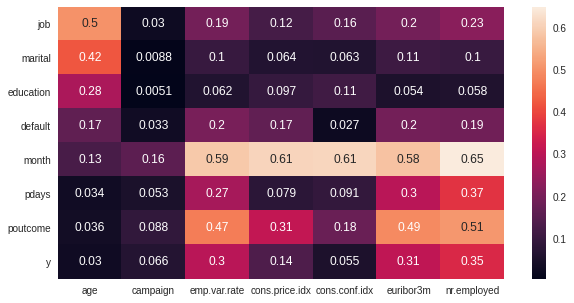

In [11]:
numeric = bank.drop(category.columns, axis = 1)

corrNumCat = []

for i in category.columns:
    mat2 = []
    for j in numeric.columns:
        mat2.append(correlation_ratio(bank[i],bank[j]))
    corrNumCat.append(mat2)

dfcramers = pd.DataFrame(corrNumCat, index = category.columns, columns = numeric.columns)
plt.figure(figsize = (10,5))
sns.heatmap(dfcramers,annot = True)